In [85]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding

## Data preparation

In [2]:
raw_data = pd.read_csv('bbc-text.csv')

In [3]:
df = raw_data.copy()

In [4]:
df.head()

,category,text
0,tech,tv future in the hands of viewers with home th...
1,business,worldcom boss left books alone former worldc...
2,sport,tigers wary of farrell gamble leicester say ...
3,sport,yeading face newcastle in fa cup premiership s...
4,entertainment,ocean s twelve raids box office ocean s twelve...


In [5]:
df.shape

(2225, 2)

In [6]:
df['category'].value_counts()

sport            511
business         510
politics         417
tech             401
entertainment    386
Name: category, dtype: int64

## Removing stop words

In [7]:
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

In [9]:
def preprocess_stop_words(text_list):
    res_list=[]
    for word in text_list:
        if word not in stop_words:
            res_list.append(word)
            
    return ' '.join(res_list)
        

In [10]:
df['pro_text'] = df['text'].str.split().apply(preprocess_stop_words)

In [11]:
df.head()

,category,text,pro_text
0,tech,tv future in the hands of viewers with home th...,tv future hands viewers home theatre systems p...
1,business,worldcom boss left books alone former worldc...,worldcom boss left books alone former worldcom...
2,sport,tigers wary of farrell gamble leicester say ...,tigers wary farrell gamble leicester say rushe...
3,sport,yeading face newcastle in fa cup premiership s...,yeading face newcastle fa cup premiership side...
4,entertainment,ocean s twelve raids box office ocean s twelve...,ocean twelve raids box office ocean twelve cri...


## Tokenization and padding sequences

In [84]:
max_words = 5000  #top 1000 common words to be included while tokenizing
max_length = 250

#initalization of tokenizer
tok = Tokenizer(num_words=max_words)

#fitting/creating words dictionary with words as key and numbers as values
#pro_text is input variable

tok.fit_on_texts(df['pro_text'].values)

#assigning df['text'] each words tokens 
#this is done separately so that test words could also be assigned tokens
X_seq = tok.texts_to_sequences(df['pro_text'].values)

In [54]:
X_seq = sequence.pad_sequences(X_seq, maxlen=max_length)
print('Shape of data tensor:', X_seq.shape)

Shape of data tensor: (2225, 250)


In [83]:
#category is target variable
y_seq = pd.get_dummies(df['category']).values

## Splitting data sequences

In [56]:
X_train, X_test, y_train, y_test = train_test_split(X_seq, y_seq, test_size=0.2, random_state=42)

In [57]:
print(X_train.shape)
print(X_test.shape)

(1780, 250)
(445, 250)


In [58]:
print(y_train.shape)
print(y_test.shape)

(1780, 5)
(445, 5)


## Model Building

In [59]:
model = Sequential()

In [60]:
model.add(Embedding(max_words,64, input_length=max_length))
model.add(LSTM(50))
model.add(Dense(5, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [61]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 250, 64)           320000    
_________________________________________________________________
unified_lstm_2 (UnifiedLSTM) (None, 50)                23000     
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 255       
Total params: 343,255
Trainable params: 343,255
Non-trainable params: 0
_________________________________________________________________


In [62]:
history = model.fit(X_train, y_train, validation_data=(X_test,y_test),epochs=20)

Train on 1780 samples, validate on 445 samples
Epoch 1/20
1780/1780 [==============================] - 5s 3ms/sample - loss: 1.4712 - accuracy: 0.3309 - val_loss: 1.2121 - val_accuracy: 0.4157
Epoch 2/20
1780/1780 [==============================] - 5s 3ms/sample - loss: 0.9534 - accuracy: 0.5888 - val_loss: 0.8307 - val_accuracy: 0.5955
Epoch 3/20
1780/1780 [==============================] - 5s 3ms/sample - loss: 0.6992 - accuracy: 0.7961 - val_loss: 1.1799 - val_accuracy: 0.5483
Epoch 4/20
1780/1780 [==============================] - 5s 3ms/sample - loss: 0.6686 - accuracy: 0.8489 - val_loss: 0.6334 - val_accuracy: 0.8225
Epoch 5/20
1780/1780 [==============================] - 5s 3ms/sample - loss: 0.2863 - accuracy: 0.9680 - val_loss: 0.4002 - val_accuracy: 0.8899
Epoch 6/20
1780/1780 [==============================] - 5s 3ms/sample - loss: 0.1190 - accuracy: 0.9871 - val_loss: 0.3156 - val_accuracy: 0.9191
Epoch 7/20
1780/1780 [==============================] - 5s 3ms/sample - loss:

In [63]:
# Final evaluation of the model
scores = model.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Accuracy: 92.81%


## Plots

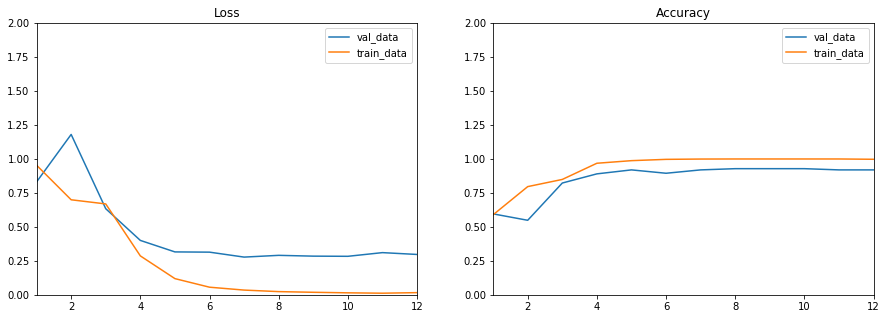

In [64]:
fig, ax = plt.subplots(1,2,figsize=(15,5))
ax[0].plot(history.history['val_loss'], label='val_data' )
ax[0].plot(history.history['loss'], label='train_data')
ax[0].axis([1,12,0,2])
ax[0].set_title('Loss')
ax[0].legend()

ax[1].plot(history.history['val_accuracy'], label='val_data')
ax[1].plot(history.history['accuracy'], label='train_data')
ax[1].axis([1,12,0,2])
ax[1].set_title('Accuracy')
ax[1].legend()
plt.show()

## Save the model

In [65]:
model.save('Model_LSTM.h5py')

## Real prediction 

In [74]:
sport_sample="Manuel Neuer has ended speculation about his future after agreeing to extend his contract at Bayern Munich until 2023."\
"The goalkeeper was linked with a move to Chelsea as replacement for Kepa Arrizabalaga, although Sky in Germany reported in March the 34-year-old was keen to stay at Bayern"\
"Negotiations proved difficult amid the Bundesliga's suspension due to the coronavirus pandemic, but Neuer has now signed the two-year extension after the German top tier resumed last weekend."\
"It was important for me to continue working with our goalkeeping coach Toni Tapalovic. Now this has been resolved, I look to the future with great optimism. I feel very comfortable and at home in Bavaria. FC Bayern are one of Europe's top football clubs"\
"During the weeks of the shutdown for the coronavirus pandemic, I didn't want to make a decision because nobody knew if, when and how Bundesliga football would continue, Neuer told the club's website."\
"Neuer will soon have competition in the form of Alexander Nubel after Bayern agreed a deal for the Schalke goalkeeper to join them ahead of the 2020-21 season."\
"And though the Bundesliga leaders appear to be building for the future as Neuer nears the final phase of his career, former Bayern goalkeeper Oliver Kahn - an executive board member at the club - says the contract extension sends out a strong message."\
"Neuer has won seven Bundesliga titles in a row with Bayern, winning the DFB-Pokal Cup on four occasions and the Champions League in 2013."\
"He played every minute of Germany's World Cup-winning campaign in 2014, and has been named in the FIFPro World XI on four occasions."

In [75]:
business_sample="Benchmark indices marched higher for the second straight day on Wednesday as robust gains in market heavyweights HDFC twins and RIL offset lacklustre global cues."\
    "The 30-share BSE Sensex climbed 622.44 points or 2.06 per cent to settle at 30,818.61, while the broader NSE Nifty rose 187.45 points, or 2.11 cent, to 9,066.55."\
    "Traders said encouraging corporate results bolstered investor confidence, though rising COVID-19 cases in India capped the gains."\
    "Further, media reports said Finance Minister Nirmala Sitharaman has not ruled out announcing more measures to help the coronavirus-hit economy, which added to the buying momentum, they added."\
    "M&M was the top gainer in the Sensex pack, surging 5.92 per cent, followed by HDFC, L&T, Tata Steel, Bajaj Finance, HDFC Bank and Sun Pharma."\
    "Only four Sensex constituents ended in the red -- IndusInd Bank, Hero MotoCorp, Bharti Airtel and Asian Paints, shedding up to 2.85 per cent."\
    "Domestic markets opened flat but gained higher later during the day led by buying across all sectors. Positive statements from the Finance Minister also could have lifted markets (and showed) that the government was with industry and would do as much as possible depending on how the coronavirus pandemic will pan out, implying there could be further stimulus ahead, said Paras Bothra, President of Equity Research, Ashika Stock Broking."\
    "BSE healthcare, capital goods, finance, consumer durables and oil and gas indices rallied up to 3.16 per cent, while telecom ended in the red."\
    "Broader BSE midcap and smallcap indices spurted up to 1.49 per cent. Global markets were largely subdued after news reports cast doubts on some COVID-19 vaccine trials."

In [76]:

labels=['business','entertainment','politics','sport','tech']

In [80]:
def predict_res(sport_sample):
    sam_list = sport_sample.split()
    test = preprocess_stop_words(sam_list) 
    testing = tok.texts_to_sequences([test])
    sam_seq = sequence.pad_sequences(testing, maxlen=max_length)
    print('Shape of data tensor:', sam_seq.shape)
    res = model.predict(sam_seq)
    print(labels[np.argmax(res)])

In [81]:
predict_res(business_sample)

Shape of data tensor: (1, 250)
business


In [82]:
predict_res(sport_sample)

Shape of data tensor: (1, 250)
sport
